In [53]:
import pandas as pd
import numpy as np
from cleantext import clean
import re
from transformers import XLNetTokenizer, XLNetForSequenceClassification, TrainingArguments, Trainer, pipeline
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import datasets 
import evaluate
import random

### Preprocess out data

In [54]:
# Should be saved in a folder called "emotions_data"
data_train = pd.read_csv('./emotions_data/emotion-labels-train.csv') 
data_test = pd.read_csv('./emotions_data/emotion-labels-test.csv')
data_val = pd.read_csv('./emotions_data/emotion-labels-val.csv')

In [55]:
data_train.head()

,text,label
0,Just got back from seeing @GaryDelaney in Burs...,joy
1,Oh dear an evening of absolute hilarity I don'...,joy
2,Been waiting all week for this game ❤️❤️❤️ #ch...,joy
3,"@gardiner_love : Thank you so much, Gloria! Yo...",joy
4,I feel so blessed to work with the family that...,joy


In [56]:
data = pd.concat([data_train, data_test, data_val], ignore_index=True)

In [57]:
data['text_clean'] = data['text'].apply(lambda x: clean(x, no_emoji=True))

In [58]:
data['text_clean'] = data['text_clean'].apply(lambda x: re.sub('@[^\s]+', '', x))

In [59]:
data.head(20)

,text,label,text_clean
0,Just got back from seeing @GaryDelaney in Burs...,joy,just got back from seeing in burslem. amazing...
1,Oh dear an evening of absolute hilarity I don'...,joy,oh dear an evening of absolute hilarity i don'...
2,Been waiting all week for this game ❤️❤️❤️ #ch...,joy,been waiting all week for this game #cheer #fr...
3,"@gardiner_love : Thank you so much, Gloria! Yo...",joy,": thank you so much, gloria! you're so sweet,..."
4,I feel so blessed to work with the family that...,joy,i feel so blessed to work with the family that...
5,"Today I reached 1000 subscribers on YT!! , #go...",joy,"today i reached 1000 subscribers on yt!! , #go..."
6,"@Singaholic121 Good morning, love! Happy first...",joy,"good morning, love! happy first day of fall. ..."
7,#BridgetJonesBaby is the best thing I've seen ...,joy,#bridgetjonesbaby is the best thing i've seen ...
8,Just got back from seeing @GaryDelaney in Burs...,joy,just got back from seeing in burslem. amazing...
9,@IndyMN I thought the holidays could not get a...,joy,i thought the holidays could not get any more...


<Axes: xlabel='label'>

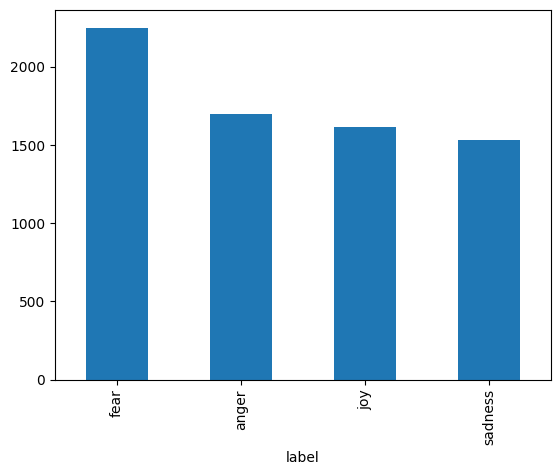

In [60]:
data['label'].value_counts().plot(kind="bar")

In [61]:
data['label_int'] = LabelEncoder().fit_transform(data['label'])

In [62]:
NUM_LABELS = 4

In [63]:
train_split, test_split = train_test_split(data, train_size = 0.8)
train_split, val_split = train_test_split(train_split, train_size = 0.9)

In [64]:
print(len(train_split))
print(len(test_split))
print(len(val_split))

5112
1421
569


In [65]:
train_df = pd.DataFrame({
    "label": train_split.label_int.values,
    "text": train_split.text_clean.values
})

test_df = pd.DataFrame({
    "label": train_split.label_int.values,
    "text": train_split.text_clean.values
})


In [66]:
train_df = datasets.Dataset.from_dict(train_df)
test_df = datasets.Dataset.from_dict(test_df)

In [67]:
dataset_dict = datasets.DatasetDict({"train":train_df, "test":test_df})

In [68]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 5112
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 5112
    })
})

### Create embeddings

In [69]:
tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")

In [70]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding = "max_length", max_length = 128, truncation=True)

In [71]:
tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)

Map:   0%|          | 0/5112 [00:00<?, ? examples/s]

Map:   0%|          | 0/5112 [00:00<?, ? examples/s]

In [72]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5112
    })
    test: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5112
    })
})

In [73]:
print(tokenized_datasets['train']['text'][0])

 #bitter sums it up! congrats nicole! that's all folks #bb18 now onto #survivor !


In [74]:
print(tokenized_datasets['train']['input_ids'][0])

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 17, 7967, 2802, 1158, 20138, 36, 76, 136, 2147, 10332, 23, 17, 6962, 5457, 136, 29, 26, 23, 71, 6119, 17, 7967, 5914, 1010, 145, 1807, 17, 7967, 4146, 13430, 218, 17, 136, 4, 3]


In [75]:
tokenizer.decode(5)

'<pad>'

In [76]:
print(tokenized_datasets['train']['token_type_ids'][0])

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2]


In [77]:
print(tokenized_datasets['train']['attention_mask'][0])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [78]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(100))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(100))

### Fine tune the model

In [79]:
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased',
                                                       num_labels=NUM_LABELS,
                                                       id2label={0: 'anger', 1: 'fear', 2: 'joy', 3: 'sadness'})

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [80]:
import numpy as np
import evaluate

accuracy_metric = evaluate.load("accuracy")
# Optional: extra metrics
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    out = {"accuracy": accuracy_metric.compute(predictions=preds, references=labels)["accuracy"]}
    # If you want F1 for multi-class (weighted):
    out["f1"] = f1_metric.compute(predictions=preds, references=labels, average="weighted")["f1"]
    return out


In [81]:
training_args = TrainingArguments(output_dir="test_trainer", eval_strategy="epoch", num_train_epochs=3)

In [82]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,  # now defined
)

In [84]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,1.326169
2,No log,1.215776
3,No log,1.122385


TrainOutput(global_step=39, training_loss=1.3609869541266026, metrics={'train_runtime': 309.7999, 'train_samples_per_second': 0.968, 'train_steps_per_second': 0.126, 'total_flos': 21366375321600.0, 'train_loss': 1.3609869541266026, 'epoch': 3.0})

### Evaluating the model

In [86]:
trainer.evaluate()

{'eval_loss': 1.122385025024414,
 'eval_runtime': 24.9205,
 'eval_samples_per_second': 4.013,
 'eval_steps_per_second': 0.522,
 'epoch': 3.0}

In [87]:
model.save_pretrained("fine_tuned_model")

In [89]:
fine_tuned_model = XLNetForSequenceClassification.from_pretrained("fine_tuned_model")

In [90]:
clf = pipeline("text-classification", fine_tuned_model, tokenizer=tokenizer)

Device set to use cpu


In [92]:
row = val_split.sample(n=1).iloc[0]
text = row['text_clean']
print(text)
answer = clf(text, top_k=None)
print(answer)


 when the lady in xmas dept answers your call as 'hello mrs xmas' yep true story #winning #xmas #cheer #goodcustomerservice
[{'label': 'anger', 'score': 0.4074285626411438}, {'label': 'sadness', 'score': 0.28091949224472046}, {'label': 'joy', 'score': 0.1820831298828125}, {'label': 'fear', 'score': 0.12956884503364563}]
